# CD38 exploration
In this notebook you can see some of the steps I took when attempting to find a better way to gate the CD38+ population. I ultimately gave up on this task after not being able to find any clear separation with the available markers

## Setup

In [1]:
import aligater as ag
import pandas as pd
import numpy as np
import math as m
from styleframe import StyleFrame, utils 
from random import randint
from datetime import date
import os
import timeit

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'aligater'

In [2]:
#Get repeats, store paths to them in 'repeats_filepaths' variable

path_to_ex = '/home/antton/TFM/data/repeats_info.xlsx'
path_to_files = "/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs" 

# # Extracting info from manually modified file
sf = StyleFrame.read_excel(path_to_ex, read_style=True, use_openpyxl_styles=False)

def only_cells_with_blue_background(cell):  # If cell has right color, give value and return. Else, leave alone.
    if cell.style.bg_color not in {utils.colors.white, '00000000'} and cell.style.bg_color not in {utils.colors.red, 'FFD9D9D9'}:
        cell.value = 'repeat'
    return cell

sf_marked = StyleFrame(sf.applymap(only_cells_with_blue_background))  # All blue cells have been noted
repeats_df = sf_marked.data_df  # DataFrame identical to the excel file with NaN for all values except for blue cells

repeats_filepaths = []  # Empty array that will contain paths to every repeat sample .fcs

for index, row in repeats_df.iterrows():  # Iterate on the DataFrame row by row
    if row.notes !='avoid' and row.notes != 'poor viability':  # Filter out crossed-out cells
        rep_locs = np.where(row.values == 'repeat')[0]  # Array with column number of blue cells
        for column_index in rep_locs:
            col_name = repeats_df.columns[column_index]  # Get actual column names (part of folder name) from index
            for folder in os.listdir(path_to_files):
                if folder.startswith(str(col_name)):  # Find the appropriate folder using the column name
                    path_into_folder = path_to_files+'/'+folder
                    for filename in os.listdir(path_into_folder):
                        if filename[3:].startswith(str(row.ID)):  # Find the specific file in folder using row ID
                            repeats_filepaths.append(path_into_folder+'/'+filename)  # Save complete filepath

/home/antton/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
/home/antton/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning:This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
/home/antton/anaconda3/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.


In [3]:
#Get all .fcs files before a certain date. Fuse this list with all the repeats.

path_to_files = "/home/antton/cbio3/data/BloodVariome/Cord Blood/fcs" 
relevant_folder_paths = []
maxdate = date(2019,9,9) #last date we are interested in
all_folders = !ls ../cbio3/data/BloodVariome/Cord\ Blood/fcs  # Take ALL the folder names in 'fcs'
for folder in all_folders:  # For each subfolder
    folder_date = date(int('20'+folder[:2]),int(folder[2:4]),int(folder[4:6]))  # Take date from folder name
    if folder_date > maxdate: # If we exceed the max date, stop
        break
    relevant_folder_paths.append(path_to_files+"/"+folder)  # Add the complete path to the subfolders

genotyped_filepaths = []  # List of all filepath to input into the experiment object.
for subfolder in relevant_folder_paths:
    #ls_path = subfolder.replace(' ','/ ')
    for file in os.listdir(subfolder):
        if file.endswith('.fcs'):
            genotyped_filepaths.append(subfolder+"/"+file)
            
final_filepaths = genotyped_filepaths + list(set(repeats_filepaths) - set(genotyped_filepaths))         

print('All repeat measurements: ', len(repeats_filepaths))
print('All genotyped files: ', len(genotyped_filepaths))
print('All relevant files: ', len(final_filepaths))
n = randint(0, len(genotyped_filepaths))
print('Example filepath: ', final_filepaths[n])

#Define experiment object
exp=ag.AGExperiment(final_filepaths, \
                    filters=['fcs'], \
                    mask=['30min','45min','Neg','test'], \
                    experiment_name="my_experiment"
                   )


All repeat measurements:  559
All genotyped files:  1068
All relevant files:  1352
Example filepath:  /home/antton/cbio3/data/BloodVariome/Cord Blood/fcs/190429 CB/D8 398.fcs


1 filter(s) defined
4 mask(s) defined
Experiment initialised with file list. Checking entries...
All file paths exists.
Collected 1204 files, 148 files did not pass filter(s) and mask(s).


In [4]:
def apply_strat(my_sample):
    #Single function that applies the complete gating strategy all the way down to the CD38 gate!
    
        #Check markers
    markers = my_sample().columns.tolist()

    for marker in markers[6:]:
        if marker.startswith('CD45'):
            CD45 = marker
        if marker.startswith('7AAD') or marker.startswith('CD235'):
            marker_7AAD = marker
        
    # - - - - Gate 1 - - - - 

    #Remove x-values that are too high
    livedead_step1 = ag.gateThreshold(my_sample, name="remove_clutter",
                                      xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                      scale='linear', T=200, yscale='bilog',
                                      thresh=214000, 
                                      parentGate=None, 
                                      orientation='vertical', population='lower')
    #Remove y-values that are too low
    livedead_step2 = ag.gateThreshold(my_sample, name="remove_clutter",
                                      xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                      scale='linear', T=200, yscale='bilog',
                                      thresh=-800, 
                                      parentGate=livedead_step1, 
                                      orientation='horisontal', population='upper')

    #Get low density point in slope of y-axis of later half
    halfcut = ag.gateThreshold(my_sample, name="remove_clutter",
                                      xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                      scale='linear', T=200, yscale='bilog',
                                      thresh=150000, 
                                      parentGate=livedead_step2, 
                                      orientation='vertical', population='upper')

    ylim_back = ag.densityDelimitation(my_sample, xCol= marker_7AAD, parentGate=halfcut,
                                       interval=[300,1100], limit_threshold=0.2,
                                       direction='right',scale='bilog',T=200)

    print('calculated ylim: ', ylim_back)
    if ylim_back == m.inf:
        ylim_back = 900
    print('used ylim: ', ylim_back)


    livedead_step3 = ag.gateThreshold(my_sample, name="lowest_density",
                                      xCol='FSC 488/10-A', yCol= marker_7AAD, 
                                      scale='linear', T=200, yscale='logish',
                                      thresh=ylim_back, 
                                      parentGate=livedead_step2, 
                                      orientation='horisontal', population='lower')


    ##  - - - - Gate 2 - - - - -

    #Cut off high FSC values
    singlets_step1 = ag.gateThreshold(my_sample, name="remove_clutter",
                                      xCol='FSC 488/10-A', yCol='FSC 488/10-H', 
                                      scale='linear', thresh=210000,
                                      parentGate=livedead_step3,  
                                      orientation='vertical', population='lower')


    #PC gate
    singlets = ag.gatePC(my_sample, name="PBMC",
                     xCol='FSC 488/10-A', yCol='FSC 488/10-H',
                     center='centroid', adjustAngle=3,widthScale=2.5,
                     heightScale=3.5, parentGate=singlets_step1)


    xlim_arbitrary = 11000

    right_half = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                      xCol='CD34 PE-Cy7-A' , yCol=CD45, 
                                      scale='bilog', T=200, thresh=xlim_arbitrary,
                                      parentGate=singlets,  
                                      orientation='vertical', population='upper')

    mean, median, sigma, maxVal = ag.axisStats(my_sample(), xCol=CD45, vI=right_half())

    upper_half = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                      xCol='CD34 PE-Cy7-A', 
                                      yCol=CD45, 
                                      scale='bilog', T=200, thresh=maxVal,
                                      parentGate=singlets,  
                                      orientation='horisontal', population='upper')

    lowr_halfof_upper_half = ag.gateThreshold(my_sample, name="remove_clutter_3",
                                      xCol='CD34 PE-Cy7-A', 
                                      yCol=CD45, 
                                      scale='bilog', T=200, thresh=maxVal+3000,
                                      parentGate=upper_half,  
                                      orientation='horisontal', population='lower')

    xlim_middle = ag.valleySeek(my_sample, xCol='CD34 PE-Cy7-A',
                        interval=[800, 11000], require_local_min=True,
                        scale='bilog', T=200, parentGate=lowr_halfof_upper_half) -1000

    CD34_step1 = ag.gateTiltedLine(my_sample, name="remove_clutter_3",
                   xCol='CD34 PE-Cy7-A' , yCol=CD45,
                   startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal+7500), theta=40,
                   scale='bilog', T=200, population='lower',
                   parentGate=singlets)

    CD34_step2 = ag.gateTiltedLine(my_sample, name="remove_clutter_3",
                   xCol='CD34 PE-Cy7-A' , yCol=CD45,
                   startPoint=(xlim_middle,maxVal), endLimits=(None, maxVal-3200), theta=-40,
                   scale='bilog', T=200, population='upper',
                   parentGate=CD34_step1)

    CD34_45pos = ag.gatePC(my_sample, name="CD34",
                     xCol='CD34 PE-Cy7-A' , yCol=CD45,
                     center='centroid', adjustAngle=3,widthScale=2.5,
                     heightScale=3.5, parentGate=CD34_step2)

    return my_sample, CD34_45pos()

# Execution 

Opening file D4 426 from folder /fcs/190513 CB
Loaded dataset with 1609243 events.


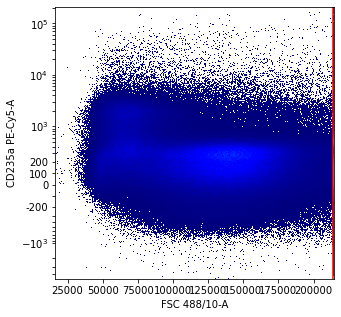

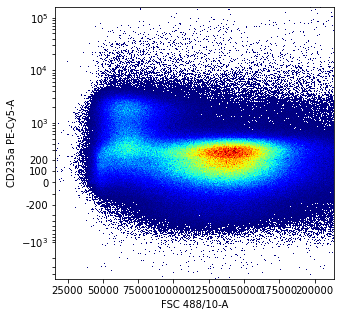

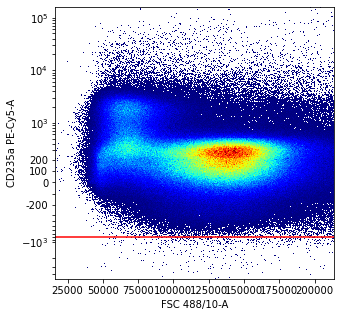

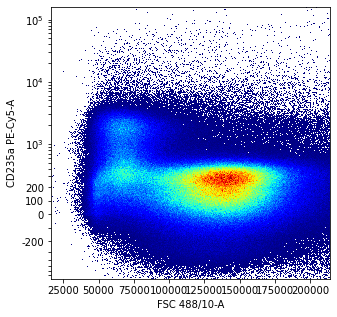

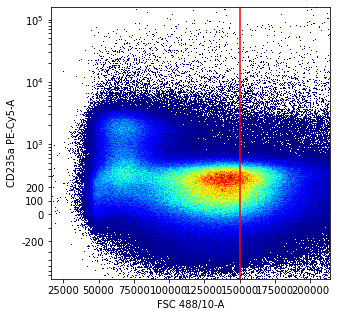

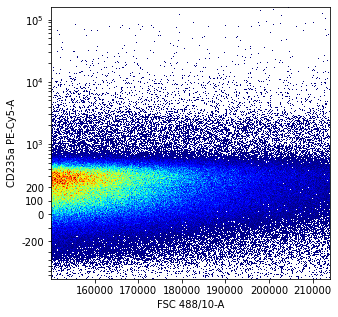

calculated ylim:  555.9765803622425
used ylim:  555.9765803622425


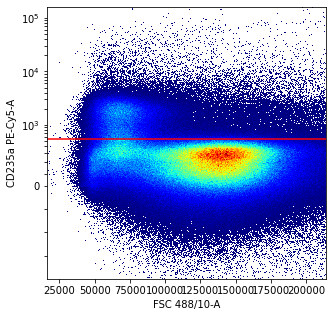

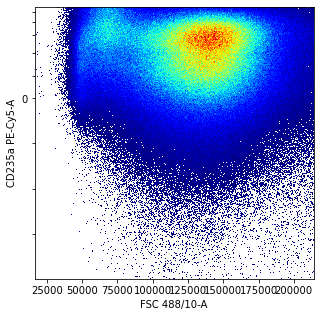

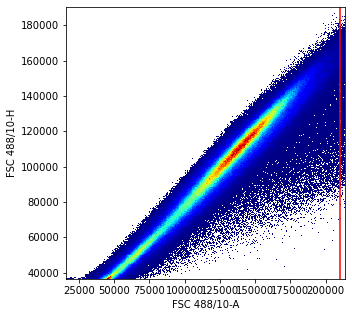

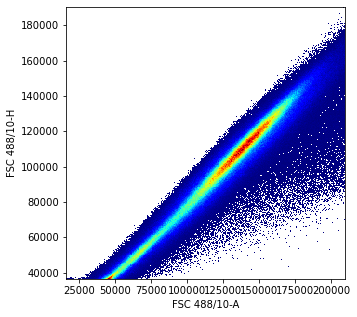

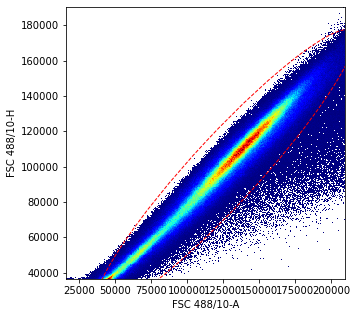

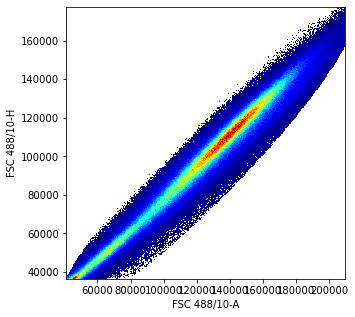

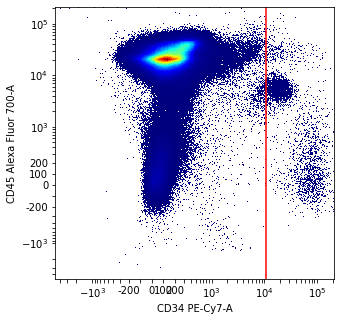

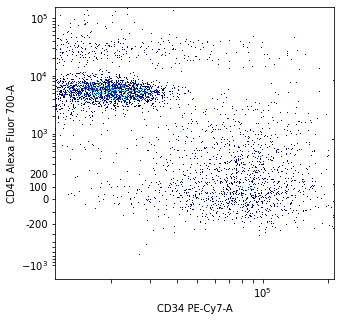

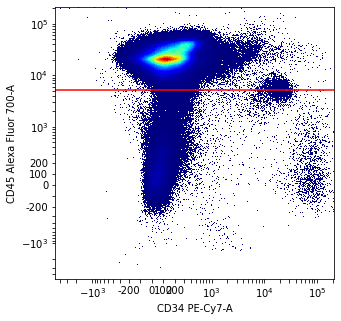

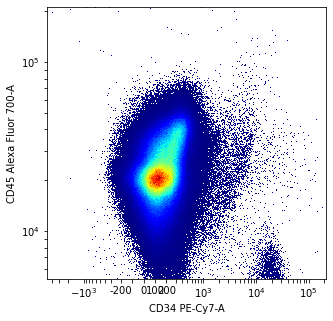

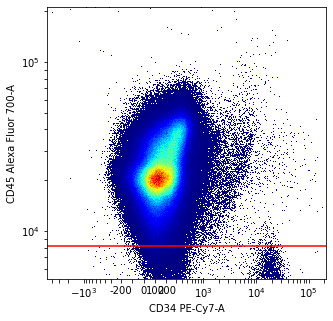

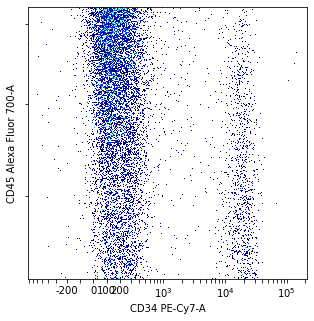

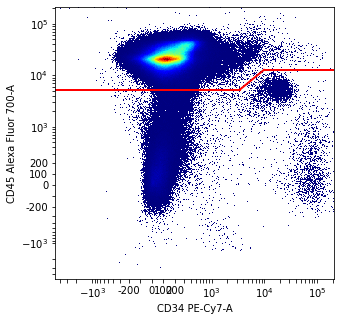

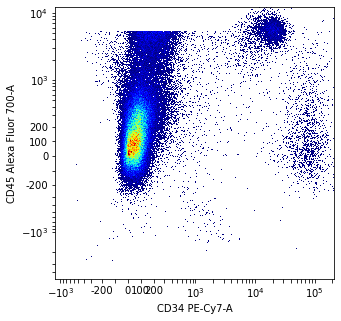

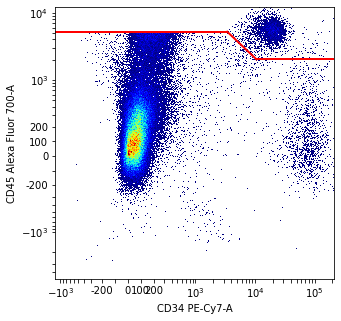

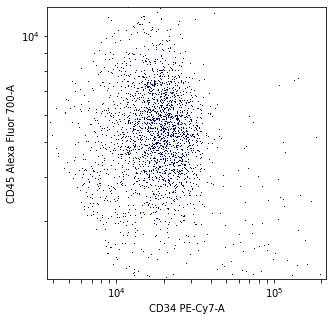

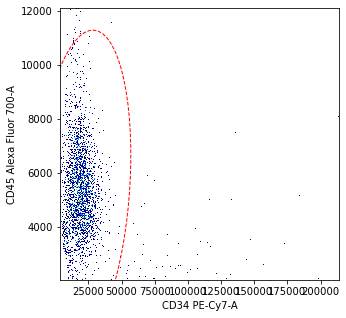

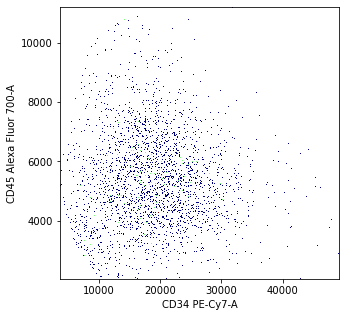

<Figure size 360x360 with 0 Axes>

In [6]:
#Run the complete gating strategy for a determined amount of random samples.
dict_dfs = dict() # Empty dictionary to store dataframse in

number_of_samples = 1
for i in range(number_of_samples):
    #n = randint(0, 1204)
    n = 449+i
    my_sample = ag.loadFCS(exp.fcsList[n], flourochrome_area_filter=True, return_type="agsample")
    if len(my_sample()) > 2500000:  ## Cap samples with too many events. Take only the first 2.5M
        my_sample.fcsDF = my_sample.fcsDF.iloc[0:2500000]
    my_sample, cell_list = apply_strat(my_sample)
    new_df = my_sample.fcsDF.loc[cell_list].copy() #DF containing the events that passed through the gate
    new_df.rename(columns={"CD45 Alexa 700-A": "CD45", "CD45 Alexa Fluor 700-A": "CD45"})
    dict_dfs["df{0}".format(i)]= new_df


In [2]:
#Fuse all DFs
#Concatenate all dataframes in the dictionary of dataframes. All column names should be the same if everying goes right
previous_df = pd.DataFrame()
for df in dict_dfs:
    previous_df = pd.concat([dict_dfs[df].rename(columns={"CD45 Alexa 700-A": "CD45", "CD45 Alexa Fluor 700-A": "CD45", "7AAD PE-Cy5-A": "7AAD", "CD235a PE-Cy5-A": "7AAD"}), previous_df])
allMarkers_df = previous_df.copy()

NameError: name 'pd' is not defined

In [1]:
allMarkers_df


NameError: name 'allMarkers_df' is not defined

## Data Exploration
Here we look at what we've got :)

### Coloring
Assign a color to the events depending on their CD38 marker values

In [10]:
# TWO COLORS Apply color to the ~30% with highest CD38

color_threshold = allMarkers_df['CD38 (BV) 421-A'].mean() #-1300 #Tag every event with CD_38 value higher than threshold by adding a new binary column
#This is for visualization porposes only, as we are looking for a way to determine the appropriate threshold.
print(color_threshold) 
tag_column = []
upper_counter = 0

for CD38value_sample in allMarkers_df['CD38 (BV) 421-A']:
    if  CD38value_sample > color_threshold:
        tag_column.append(1)
        upper_counter += 1

    else:
        tag_column.append(0)
allMarkers_df['CD38-positive'] = tag_column
num_all_events = len(allMarkers_df['CD38 (BV) 421-A'])
print('Percentage of upper values colored: ', upper_counter/num_all_events * 100, '%')


1461.5378769686545
Percentage of upper values colored:  24.800277874261898 %


In [13]:
# THREE COLORS Apply color to the ~30% with highest CD38 AND to the ~30% with the LOWEST

color_upper_threshold = allMarkers_df['CD38 (BV) 421-A'].mean() #-1300 #Tag every event with CD_38 value higher than threshold by adding a new binary column
color_lower_threshold = color_upper_threshold - 900
#This is for visualization porposes only, as we are looking for a way to determine the appropriate threshold.
print('Upper limit: ', color_upper_threshold)
print('Upper limit: ', color_lower_threshold) 

tag_column = []
upper_counter = 0
lower_counter = 0
for CD38value_sample in allMarkers_df['CD38 (BV) 421-A']:
    if  CD38value_sample > color_upper_threshold:
        tag_column.append(2)
        upper_counter += 1
    elif CD38value_sample < color_lower_threshold:
        tag_column.append(0)
        lower_counter += 1
    else:
        tag_column.append(1)
allMarkers_df['CD38-positive'] = tag_column

num_all_events = len(allMarkers_df['CD38 (BV) 421-A'])
print('Percentage of upper values colored: ', upper_counter/num_all_events * 100, '%')
print('Percentage of lower values colored: ', lower_counter/num_all_events * 100, '%')


Upper limit:  1461.5378769686545
Upper limit:  561.5378769686545
Percentage of upper values colored:  24.800277874261898 %
Percentage of lower values colored:  30.739840222299406 %


## Defining sub-DFs

In [14]:
# ONE COLOR Create sub-df with only markers of interest to calculate PCs on

markers = list(allMarkers_df.columns)
#relevant_markers = ['CD38 (BV) 421-A', 'CD34 PE-Cy7-A', 'CD45 Alexa 700-A', 'CD45RA FITC-A','CD90 PE (R-phycoerythrin)-A' ]
abrev_list = [ 'CD34 ', 'CD90 ', 'CD135', 'CD16', 'CD38 ', 'CD14 ', 'CD45']
relevant_markers = []
for marker in markers:
    abreviation = marker[:5]
    if abreviation in abrev_list and marker != 'CD38-positive': #if the marker is in the relevant list, add it
        relevant_markers.append(marker)
print(relevant_markers)
# None of the created "sub-dfs" have the color column
df = allMarkers_df[relevant_markers].copy() #Only markers of interest. 
df_all = allMarkers_df.loc[:, allMarkers_df.columns != 'CD38-positive'].copy() #All markers, no "color" column
df_no38 = df.loc[:, df.columns != 'CD38 (BV) 421-A'].copy() #Same as df but no CD38 column
df_all_no38 = df_all.loc[:, df_all.columns != 'CD38 (BV) 421-A'].copy() #Same as df_all but no CD38 column

tags = allMarkers_df['CD38-positive']
#print('Colored '+ str(sum(tags)) +' events out of '+str(len(tags))+ ', a '+ str(sum(tags)/len(tags)*100)+' %')


['CD34 PE-Cy7-A', 'CD90 PE (R-phycoerythrin)-A', 'CD135 (BV) 711-A', 'CD38 (BV) 421-A', 'CD14 (BV) 605-A', 'CD45']


In [15]:
print('df: ', df.columns)
print('df_all: ',df_all.columns)
print('df_no38: ', df_no38.columns)
print('df_all_no38: ',df_all_no38.columns)

df:  Index(['CD34 PE-Cy7-A', 'CD90 PE (R-phycoerythrin)-A', 'CD135 (BV) 711-A',
       'CD38 (BV) 421-A', 'CD14 (BV) 605-A', 'CD45'],
      dtype='object')
df_all:  Index(['FSC 488/10-H', 'FSC 488/10-A', 'FSC 488/10-W', 'SSC 488/10-H',
       'SSC 488/10-A', 'SSC 488/10-W', 'CD45RA FITC-A', 'CD8 PerCP-Cy5.5-A',
       'CD34 PE-Cy7-A', '7AAD', 'CD90 PE (R-phycoerythrin)-A',
       'CD19 PE-Texas Red-A', 'CD56 (BV) 650-A', 'CD135 (BV) 711-A',
       'CD16 (BV) 786-A', 'CD38 (BV) 421-A', 'CD14 (BV) 605-A',
       'CD4 (BV) 510-A', 'CD45', 'CD3 APC-H7-A',
       'CD10 APC (Allophycocyanin)-A'],
      dtype='object')
df_no38:  Index(['CD34 PE-Cy7-A', 'CD90 PE (R-phycoerythrin)-A', 'CD135 (BV) 711-A',
       'CD14 (BV) 605-A', 'CD45'],
      dtype='object')
df_all_no38:  Index(['FSC 488/10-H', 'FSC 488/10-A', 'FSC 488/10-W', 'SSC 488/10-H',
       'SSC 488/10-A', 'SSC 488/10-W', 'CD45RA FITC-A', 'CD8 PerCP-Cy5.5-A',
       'CD34 PE-Cy7-A', '7AAD', 'CD90 PE (R-phycoerythrin)-A',
       'CD19 

In [16]:
from scipy.stats import pearsonr,spearmanr

for marker in df_all.columns.tolist():
    # calculate Spearman's correlation
    scorr, p_sp = spearmanr(df_all['CD38 (BV) 421-A'], df_all[marker])
    if abs(scorr) > 0.21:
        print('For marker '+marker+', Spearmans correlation: %.3f' % scorr, ' p-value: ', p_sp)


For marker SSC 488/10-W, Spearmans correlation: 0.254  p-value:  8.81661204399095e-44
For marker CD90 PE (R-phycoerythrin)-A, Spearmans correlation: -0.365  p-value:  1.6573222549088437e-91
For marker CD135 (BV) 711-A, Spearmans correlation: 0.238  p-value:  1.8847085015530362e-38
For marker CD38 (BV) 421-A, Spearmans correlation: 1.000  p-value:  0.0
For marker CD10 APC (Allophycocyanin)-A, Spearmans correlation: -0.319  p-value:  2.7935977663747424e-69


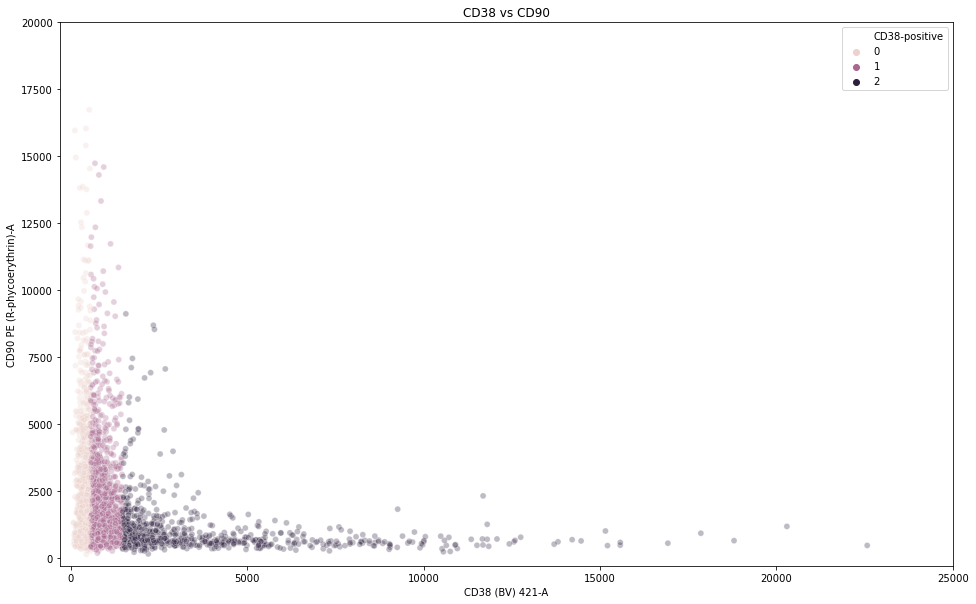

In [17]:
plt.figure(figsize=(16,10))
plt.title('CD38 vs CD90')
plt.xlim(-300,25000)
plt.ylim(-300,20000)

sns.scatterplot(
    x='CD38 (BV) 421-A', y="CD90 PE (R-phycoerythrin)-A",
    hue=tags,
    data=df,
    legend="full",
    alpha=0.3
)

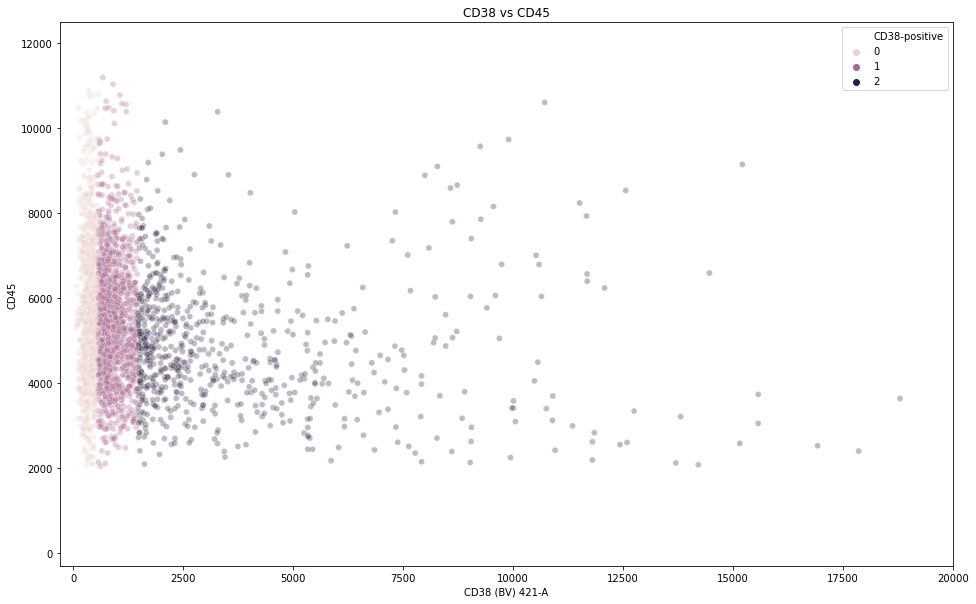

In [18]:
plt.figure(figsize=(16,10))
plt.title('CD38 vs CD45')
plt.xlim(-300,20000)
plt.ylim(-300,12500)

sns.scatterplot(
    x='CD38 (BV) 421-A', y="CD45",
    hue=tags,
    data=df,
    legend="full",
    alpha=0.3
)

# PCA

In [19]:
comps = 3 #Number of desired components (max 10)

df_to_use = df #REMEMBER TO ALWAYS RE-RUN THE CELL THAT DEFINES THE DFs!!!

print(df_to_use)

pca = PCA(n_components=comps)
pca_result = pca.fit_transform(df_to_use.values)
num_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eigth', 'nine', 'ten']
for i in range(comps):
    df_to_use['pca-'+num_list[i]] = pca_result[:,i]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

         CD34 PE-Cy7-A  CD90 PE (R-phycoerythrin)-A  CD135 (BV) 711-A  \
48        21541.446604                   984.689776        254.705299   
2090      11790.974599                   547.146717        478.370497   
2314      24738.588095                   539.190216        346.953539   
2687      19768.599845                   708.922359        133.988943   
3048      18616.586081                  2556.483482        104.582279   
...                ...                          ...               ...   
1607917   18876.184995                   934.114155        258.732005   
1608724   41129.845867                  1652.731565        272.435848   
1608744    9125.472663                  1381.239028        221.050012   
1608959   16820.432414                  1221.856881         62.440151   
1609166   17421.767823                   354.526527         31.837487   

         CD38 (BV) 421-A  CD14 (BV) 605-A         CD45  
48           1198.416551       266.798406  5324.206420  
2090     

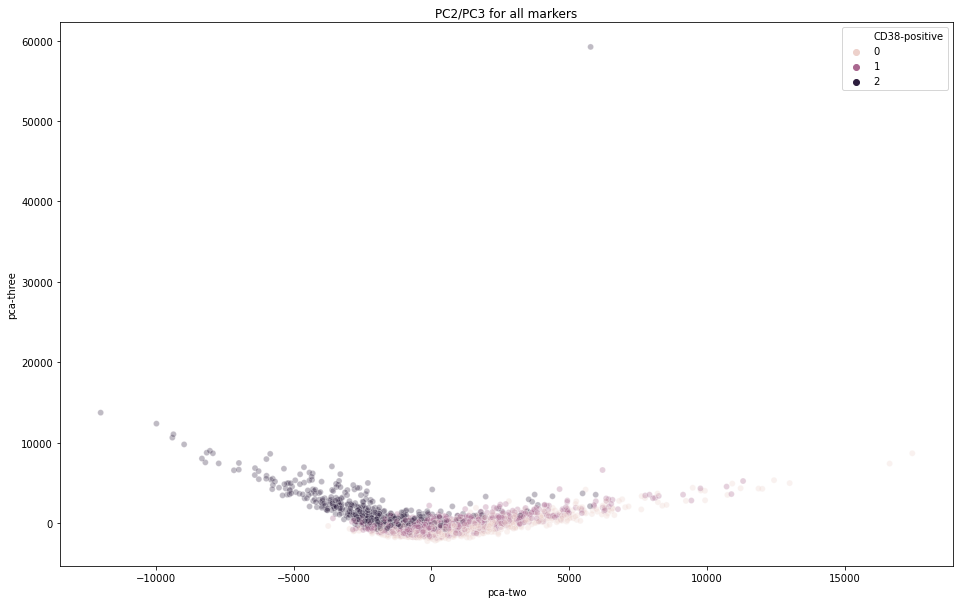

In [20]:
#PC2 and PC3

plt.figure(figsize=(16,10))
plt.title('PC2/PC3 for all markers')
sns.set_palette("Reds")
#plt.xlim(-30000,50000)
#plt.ylim(-6000,40000)

sns.scatterplot(
    x="pca-two", y="pca-three",
    hue=tags,
    data=df_to_use,
    legend="full",
    alpha=0.3
)

In [ ]:
#PC2 and PC1

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-two", y="pca-one",
    hue=tags,
    #palette=sns.color_palette("hls", 10),
    data=df_to_use,
    legend="full",
    alpha=0.3
)

In [ ]:


plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-three", y="pca-one",
    hue=tags,
    #palette=sns.color_palette("hls", 10),
    data=df_to_use,
    legend="full",
    alpha=0.3
)

In [ ]:
# Original gate

plt.figure(figsize=(16,10))
plt.ylim(0,40000)
sns.scatterplot(
    x='CD34 PE-Cy7-A' , y='CD38 (BV) 421-A',
    hue=tags,
    #palette=sns.color_palette("hls", 10),
    data=df_all,
    legend="full",
    alpha=0.3
    
)


# tSNE

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 2879 samples in 0.003s...
[t-SNE] Computed neighbors for 2879 samples in 0.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2879
[t-SNE] Computed conditional probabilities for sample 2000 / 2879
[t-SNE] Computed conditional probabilities for sample 2879 / 2879
[t-SNE] Mean sigma: 410.234384
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.876457
[t-SNE] KL divergence after 400 iterations: 0.744114


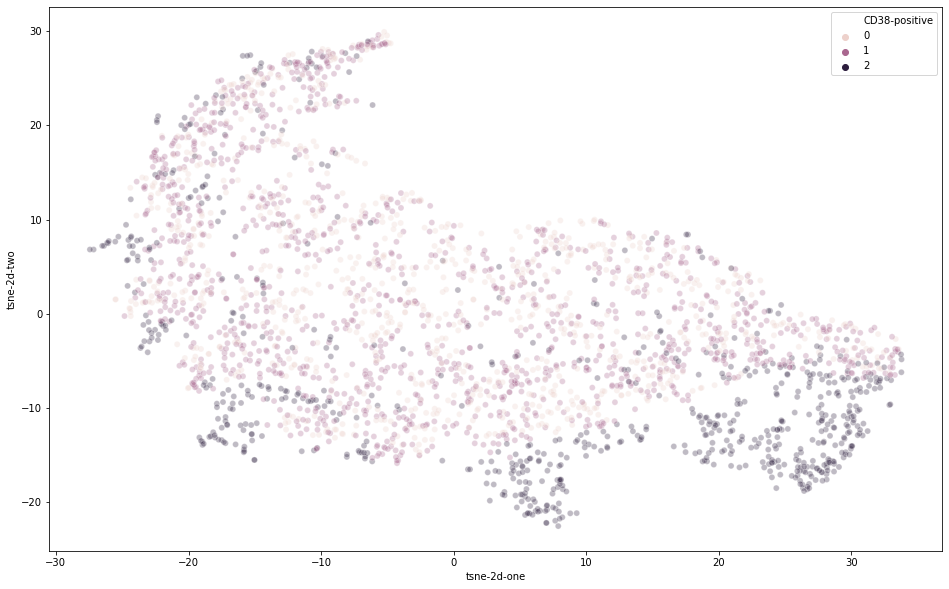

In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=400)
tsne_results = tsne.fit_transform(df_to_use.values)
df_to_use['tsne-2d-one'] = tsne_results[:,0]
df_to_use['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=tags,
    data=df_to_use,
    legend="full",
    alpha=0.3
)

In [ ]:
plt.figure(figsize=(16,10))
plt.title('tSNE with curated markers, perplexity = 80')
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=tags,
    data=df_to_use,
    legend="full",
    alpha=0.3
)

# K-means

In [ ]:
pcs_and_markers = list(df_all.columns)
pcs_and_markers

In [ ]:
import itertools
from sklearn.cluster import KMeans

all_pc_marker_combos = list(itertools.permutations(pcs_and_markers[6:], r=2))
#print(all_pc_marker_combos)

In [ ]:
#Multi k-NN figures

#The idea here is that knn will find clusters for each pair of markers, and some pairs might correlate with CD38 values
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(16,8))
 

for i, ax in zip(range(20), axes.flat):
    ax.set_ylim(-1000,50000)
    pair = all_pc_marker_combos[i]

    ax.set_title(str(pair))
    kmeans = KMeans(n_clusters=2).fit(df_to_use[[pair[0],pair[1]]])

    
    sns.scatterplot(x=df_to_use['CD34 PE-Cy7-A'], y=df_to_use['CD38 (BV) 421-A'], hue= kmeans.labels_.astype(float), ax=ax)
plt.show()

In [ ]:


kmeans = KMeans(n_clusters=2).fit(df_to_use)

f, ax = plt.subplots(figsize=(7, 7))
ax.set(ylim=(-10000, 50000))
splot = sns.scatterplot(x=df_all['CD34 PE-Cy7-A'], y=df_all['CD38 (BV) 421-A'], hue= kmeans.labels_.astype(float),ax=ax, s=50, alpha=0.5)
